In [1]:
import xgboost as xgb

In [2]:
model = xgb.Booster()
model.load_model('experiments/models/train-until-2023_variance=0.2_col_length=68.model')
model

In [3]:
# Get the textual representation of the trees
tree_dump = model.get_dump()

# Save the tree structure to a text file
with open('tree_structure.txt', 'w') as file:
    for i, tree in enumerate(tree_dump):
        file.write(f"Tree {i}:\n{tree}\n\n")

When visualizing a decision tree in an ensemble like XGBoost, you might want to focus on visualizing one of the individual trees rather than the entire ensemble. Visualizing an individual tree provides insights into the decision-making process of that specific tree, which may be representative of the overall behavior of the model.

Here are some guidelines on which tree to choose for visualization:

- First Tree (Index 0): The first tree often serves as a good starting point for visualization. It captures the initial patterns in the data and represents the model's initial understanding.
- Middle Trees: If you have a large number of trees, visualizing trees from the middle of the ensemble may give you a sense of how the model evolves during training.
- Last Tree: The last tree in the ensemble reflects the final learned patterns and corrections. It may be interesting to see how the model has refined its predictions over the boosting rounds.

Choose the tree that best fits your analysis objectives. Keep in mind that visualizing the entire ensemble might be overwhelming, and understanding individual trees can provide more focused insights into the model's decision logic. Additionally, graphical visualization tools like Graphviz or XGBoost's built-in plot_tree function can help you create more interpretable visual representations of the decision tree.

<Axes: >

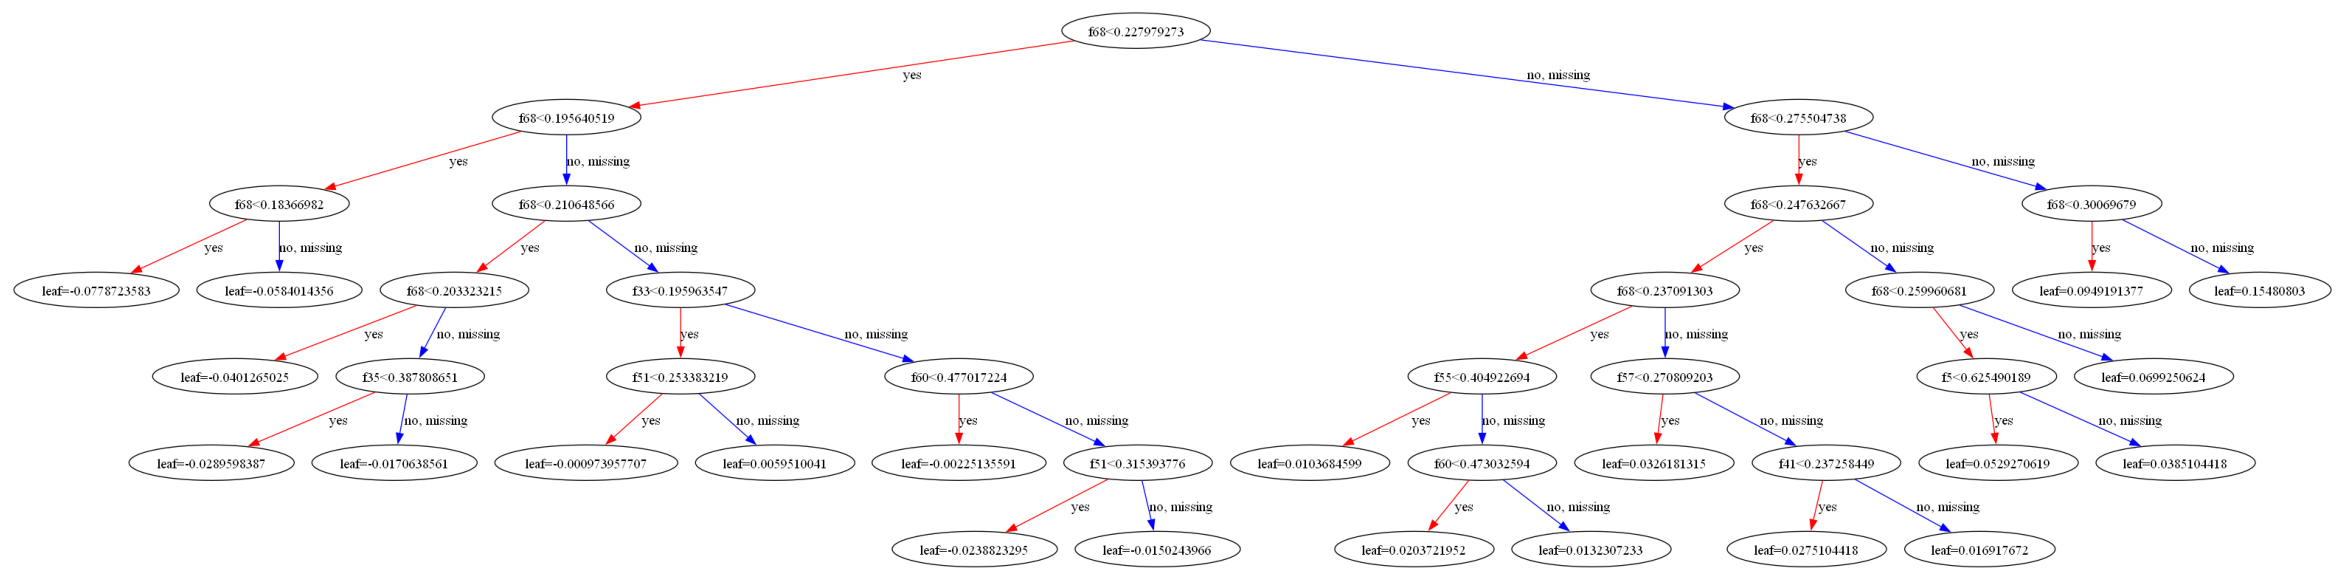

In [17]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(figsize=(30, 20))
xgb.plot_tree(model, num_trees=0, ax=ax)


### Feature Engineering for Ridge Regression

In [4]:
import os
import pickle
from datetime import datetime

import numpy as np
import pandas as pd

import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler

# from data import data
# from model import model

import billiard as multiprocessing
import matplotlib.pyplot as plt
import tsfresh
from tsfresh import extract_features, select_features, extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import Ridge
import pickle
from sklearn.preprocessing import MinMaxScaler
from pandas.tseries.offsets import BDay

import json
import sys


In [6]:
import os
import pickle
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import xgboost as xgb

from sklearn.preprocessing import MinMaxScaler
import graphviz


def show_plot(df, save_path, pred='preds'):
    agg_data = df.copy()
    agg_data.pricing_date = pd.to_datetime(agg_data.pricing_date)
    agg_data.forecast_date = agg_data.forecast_date.astype(str)

    agg_data = agg_data.set_index('pricing_date')

    df = agg_data.copy()
    df = df.sort_index(ascending=True)

    fig = px.line(df, x=df.index, y=pred, color='forecast_date', markers=True, height=600, width=1200)
    fig.update_traces(opacity=0.5, line=dict(width=2, ))

    df = agg_data.copy()
    df = df.sort_index(ascending=True)

    x = df.index
    y = df['target']
    name = 'target'
    fig.add_trace(
        go.Scatter(x=x, y=y, name=name, mode='lines+markers', opacity=0.5, marker=dict(color='darkgray', size=10),
                   line=dict(width=18, color='gray')))  # ,shape = 'hv'
    fig.write_image(save_path)


In [7]:
today = '2024-01-15'
z_values = [10**5, 10**6, 10**7]
models = []

ti = {
        'train_start': '2017-03-21',
        'train_end': str(datetime.today())[:10],
        'test_start': str(datetime.today())[:10],
        'test_end': str(datetime.today() + BDay(10))[:10],
        'save_path': f'experiments/{today}',
        'target_col': 'F380 M2/M3'
}

df = pd.read_csv(f'data/data_{today}.csv')
        
assert isinstance(df, pd.DataFrame) and len(df) > 0, 'The dataset does not exist! [@main.py, L:220]'

# convert dates
df.pricing_date = pd.to_datetime(df.pricing_date)
df.set_index('pricing_date', inplace=True)

# slice from train_start until test_end
df = df[(df.index >= ti['train_start']) & (df.index < ti['test_end'])]
df.interpolate(method='linear', inplace=True)
df.fillna(0, inplace=True)

features, target = df.drop(columns=ti['target_col']), df[ti['target_col']]
features.reset_index(inplace=True)

# target.fillna(0, inplace=True)
# features.interpolate(inplace=True)

# interpolate values (interpolation does not 'guess' the future values, they still end up being NaN)
# features.interpolate(inplace=True)
# target.interpolate(inplace=True)
# target.fillna(inplace=True)     # otherwise breaks the ridge implementation

# extract relevant features that were already ran (saves a lot of time)
kind_fc_params = json.load(open('data/kind_fc_params.json'))
features_filtered = tsfresh.extract_features(features, column_sort='pricing_date', column_id='pricing_date', kind_to_fc_parameters=kind_fc_params, n_jobs=4)
impute(features_filtered)


def train(z, features, target, test_start):
        y = target
        
        results_df = pd.DataFrame(columns=['pricing_date', 'preds', 'target', 'forecast_date'])

        t_values = y[y.index >= test_start].index

        for t in t_values:
            test_start = str(t)[:10]
            
            R = y[y.index < test_start]                                         # y_train
            R_s = y[y.index >= test_start]                                      # y_test
            S = features[features.index < test_start]                           # x_train
            S_t = features[features.index >= test_start]                        # x_test

            beta = Ridge(alpha=z, solver='svd', fit_intercept=False).fit(S, R).coef_
            
            forecast = S_t @ beta

            results_df = pd.concat([results_df, pd.DataFrame({
                'pricing_date': [test_start],
                'preds': [forecast.values[0]],
                'target': [R_s.values[0]],
            })], ignore_index=True)
                        
            results_df.to_excel(os.path.join(f'tsfresh_virtue_z={z}.xlsx'), sheet_name=f'z={z}')
            show_plot(results_df, os.path.join(f'tsfresh_virtue_z={z}.png'))
            models.append(beta)
            
for z in z_values:
    train(z, features_filtered.copy(), target.copy(), test_start=ti['test_start'])

Feature Extraction: 100%|██████████| 20/20 [00:38<00:00,  1.92s/it]


In [12]:
feature_importance10_5 = pd.DataFrame({'column': features_filtered.columns, 'importance': models[0]})
feature_importance10_5.sort_values('importance', ascending=False).head(15)

,column,importance
237,ENOC__abs_energy,0.033415
807,SOCAR__abs_energy,0.013406
43,BPSG__quantile__q_0.8,0.012665
45,BPSG__quantile__q_0.6,0.012665
48,BPSG__quantile__q_0.1,0.012665
50,BPSG__minimum,0.012665
52,BPSG__maximum,0.012665
47,BPSG__quantile__q_0.3,0.012665
39,BPSG__absolute_maximum,0.012665
51,BPSG__mean,0.012665


In [13]:
feature_importance10_6 = pd.DataFrame({'column': features_filtered.columns, 'importance': models[1]})
feature_importance10_6.sort_values('importance', ascending=False).head(15)

,column,importance
237,ENOC__abs_energy,0.033415
807,SOCAR__abs_energy,0.013406
39,BPSG__absolute_maximum,0.012664
45,BPSG__quantile__q_0.6,0.012664
42,BPSG__quantile__q_0.9,0.012664
41,"BPSG__fft_coefficient__attr_""real""__coeff_0",0.012664
44,BPSG__quantile__q_0.7,0.012664
56,BPSG__median,0.012664
46,BPSG__quantile__q_0.4,0.012664
47,BPSG__quantile__q_0.3,0.012664


In [14]:
feature_importance10_7 = pd.DataFrame({'column': features_filtered.columns, 'importance': models[2]})
feature_importance10_7.sort_values('importance', ascending=False).head(15)

,column,importance
237,ENOC__abs_energy,0.033413
807,SOCAR__abs_energy,0.013407
52,BPSG__maximum,0.012658
46,BPSG__quantile__q_0.4,0.012658
45,BPSG__quantile__q_0.6,0.012658
40,"BPSG__fft_coefficient__attr_""abs""__coeff_0",0.012658
51,BPSG__mean,0.012658
53,BPSG__root_mean_square,0.012658
42,BPSG__quantile__q_0.9,0.012658
48,BPSG__quantile__q_0.1,0.012658
